## TimeSeries Analysis of Atmospheric CO

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import itertools
import warnings
warnings.filterwarnings('ignore')

#### Loading Time-series Data

The analysis will utilize the dataset titled "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A." This dataset comprises CO2 measurements collected from March 1958 to December 2001. 

In [25]:
data = sm.datasets.co2.load_pandas()
df = data.data
df.head(5)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


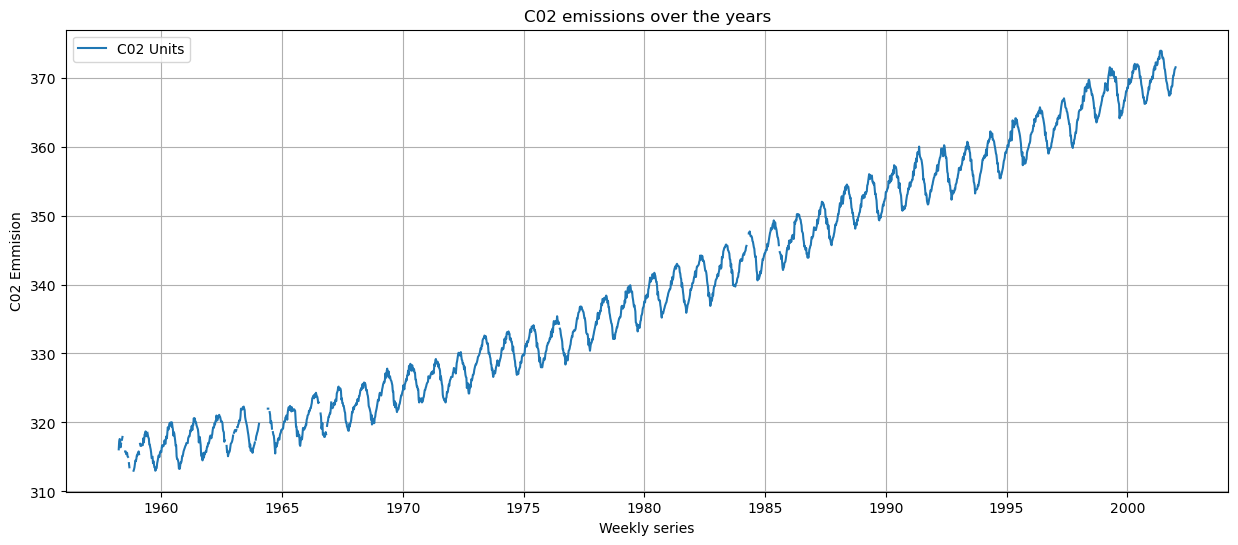

In [26]:
fig = plt.figure(figsize = (15,6))
plt.plot(df.index, df.co2, label='C02 Units', linestyle='-')
plt.title('C02 emissions over the years')
plt.xlabel("Weekly series")
plt.legend(fontsize=10)
plt.ylabel("C02 Emmision")
plt.grid(True)
plt.show()

Weekly data can be challenging to work with due to its shorter timeframe. Therefore, it is convertrd into monthly averages using the "resample" function. 

In [27]:
# The 'MS' string groups the data in buckets by start of the month
ts = df['co2'].resample('MS').mean()
ts.head(5)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

####  Handling Missing Values 

In [28]:
ts.isnull().sum()

5

This output tells us that there are 5 months with missing values in our time series.

Backward fill, also known as backfilling, is a common technique in time series data analysis where missing values are filled with the most recent available observation. This method helps maintain the temporal sequence of data and is often employed when past values are assumed to be relevant or appropriate for imputing missing observations.

In [29]:
ts = ts.fillna(method='bfill')

With missing values filled in, we can once again check to see whether any null values exist to make sure that our operation worked:

In [30]:
ts.isnull().sum()

0

### Data Exploration and estimation of model parameters

When dealing with time-series data, visualization can unveil valuable insights. Key aspects to examine include:

- **Seasonality:** Is there a discernible recurring pattern within the data?
- **Trend:** Does the data exhibit a consistent upward or downward trajectory?
- **Noise:** Are there outliers or missing values that deviate from the data's overall consistency?

#### Componenets of Time Series Data

In [31]:
# Series containing only months
month = ts.index.month.astype(str)

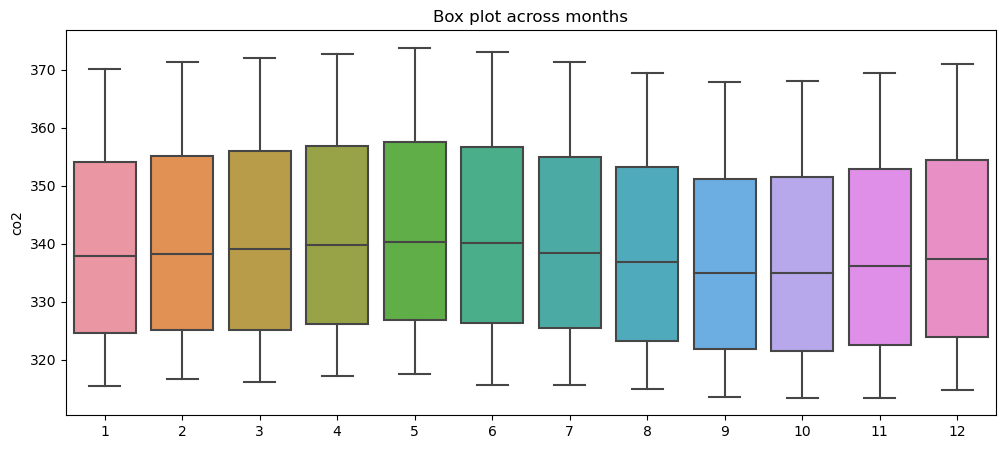

In [32]:
# Create a list of months in ascending order
ordered_months = [str(i) for i in range(1, 13)]

fig = plt.figure(figsize=(12, 5))
sns.boxplot(x=month, y=ts, order=ordered_months)
plt.title('Box plot across months')
plt.show()


The observation reveals that the box plots for CO2 emissions in each month exhibit a consistent pattern of gradual increase up to the sixth month, followed by a gradual decrease. This pattern suggests a minor spike in CO2 emissions during the sixth month, indicating a particular period characterized by increased emissions.

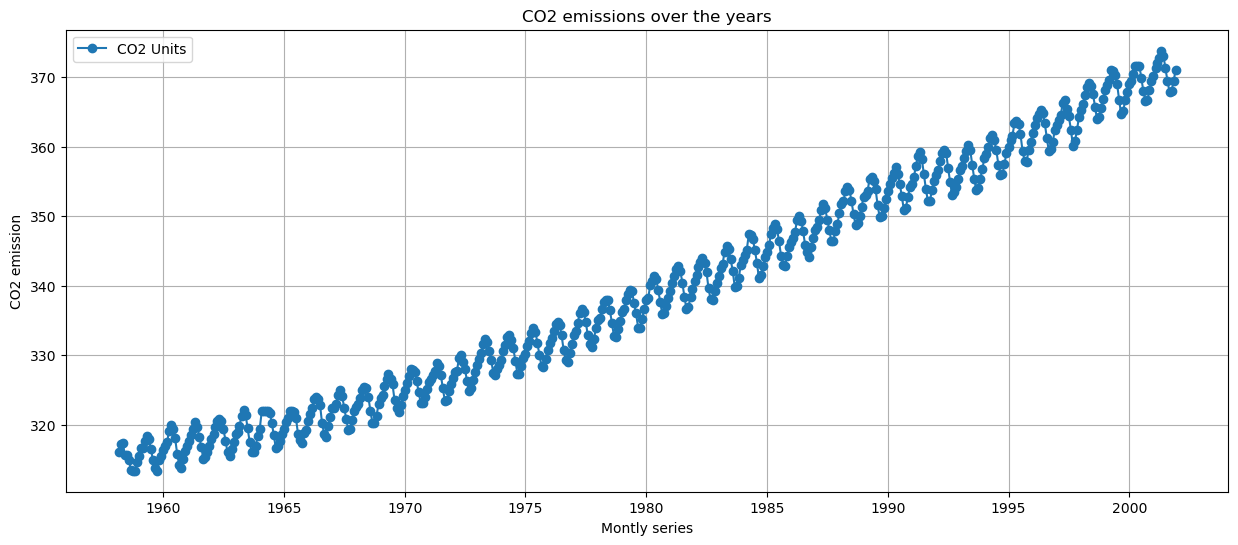

In [33]:
fig = plt.figure(figsize = (15,6))
plt.plot(ts.index, ts, label='CO2 Units', linestyle='-', marker='o')
plt.title('CO2 emissions over the years')
plt.xlabel("Montly series")
plt.legend(fontsize=10)
plt.ylabel("CO2 emission")
plt.grid(True)
plt.show()

- The time-series exhibits clear seasonality, as well as an overall increasing trend. 

- The series appears to follow a linear trend, which means there is a consistent upward movement in CO2 emissions over time. This component is additive as it contributes a constant amount to the data over time.

- Seasonality is also considered additive because it adds a fixed amount of variation to the data at each seasonal interval.

We can also visualize our data using a method called time-series decomposition. As its name suggests, time series decomposition allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

The additive model assumes that the observed data can be expressed as the sum of these three components:

Observed Data = Trend + Seasonality + Noise

This approach simplifies the analysis by breaking down the time series into interpretable and additive parts, making it easier to understand the underlying patterns and sources of variation.

In [34]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')

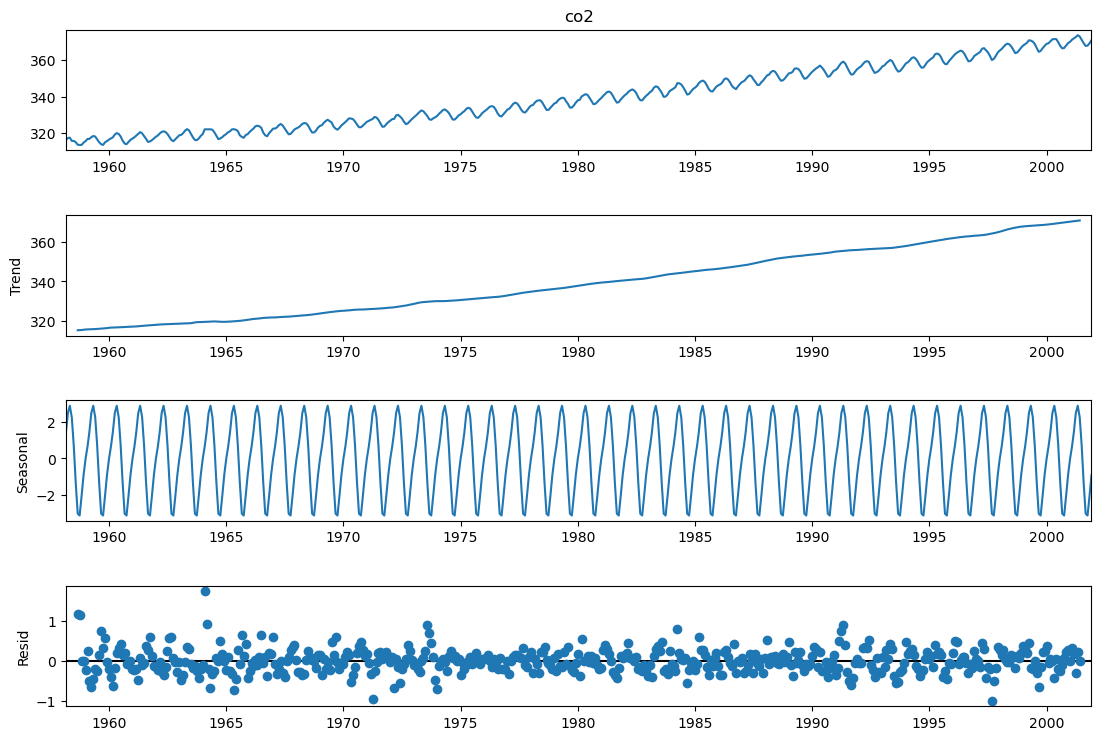

In [35]:
from pylab import rcParams
#rcParams['figure.figsize'] = 12, 10
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

Time series decomposition simplifies the process of detecting shifts in the data's mean or variability. The provided plot distinctly illustrates the upward trend in the data and its annual seasonality.

#### Estimating model parameters

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **A**uto**R**egressive **I**ntegrated **M**oving **A**verage. 

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. 

+ **p** represents the auto-regressive component of the model, enabling the incorporation of past values' influence into our model.

+ **d** signifies the integrated part of the model, encompassing terms that account for differencing, indicating how many past time points should be subtracted from the current value to make the time series stationary.

+ **q** stands for the moving average aspect of the model, permitting the modeling of errors as a linear combination of past error values observed at earlier time points.

As the data is clearly not Stationary, the time series is differentiated once to make it stationary

In [36]:
# First difference of the time series
first_diff = ts.diff().dropna()

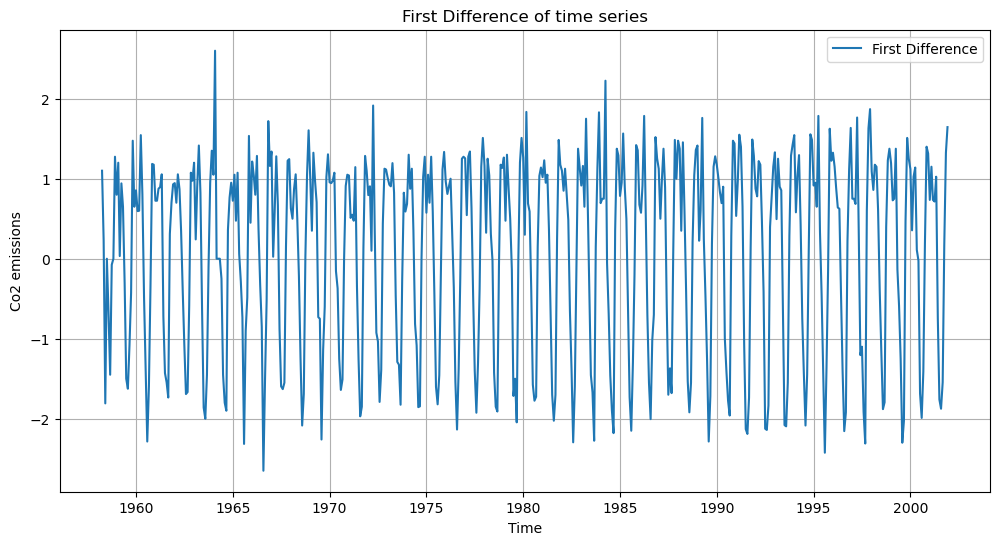

In [37]:
# Create a plot for the first difference
plt.figure(figsize=(12, 6))
plt.plot(first_diff, label='First Difference')
plt.xlabel('Time')
plt.ylabel('Co2 emissions')
plt.title('First Difference of time series')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# Tests for Stationarity
from statsmodels.tsa.stattools import adfuller

#ADF test for stationarity on first differnce series

#H0: Series is Not Stationary
adf_test = adfuller(first_diff)
adf_test_pvalue = adf_test[1]
adf_test_pvalue

1.6614851317683852e-05

As p-value of ADF test < 0.05, H0 can be rejected.

Thus, the first difference of the time series is stationary

Hence, d = 1

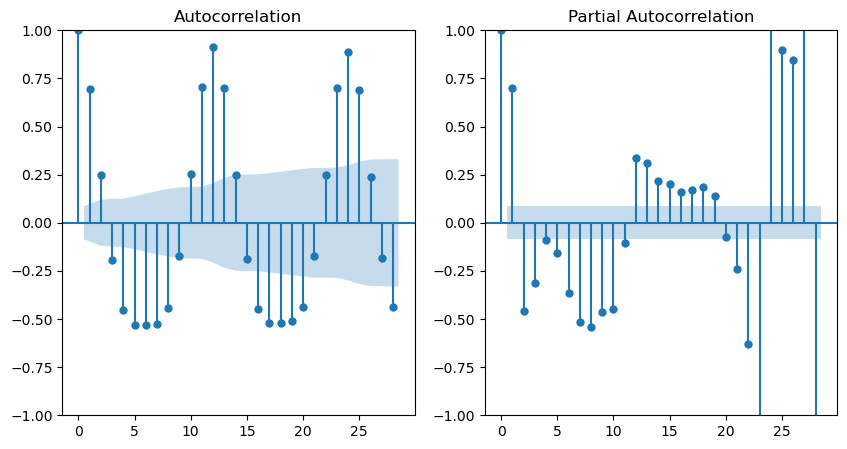

In [39]:
# Using First Difference Data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# ACF
sm.graphics.tsa.plot_acf(first_diff, lags=28, ax=ax[0])

# PACF
sm.graphics.tsa.plot_pacf(first_diff, lags=28, ax=ax[1])

plt.show()

- In ACF plot, at every 12th lag the pattern repeats, indicating seasonality.
- The patterns of ACF and PACF suggest the presence of both AR(p) and MA(q) components.

When addressing seasonal effects, we employ a seasonal ARIMA model, represented as SARIMA(p, d, q)(P, D, Q)_s. In this notation, (p, d, q) correspond to the non-seasonal parameters as previously described, while (P, D, Q) carry the same meaning but are applied to the seasonal component of the time series. The term "s" denotes the periodicity of the time series, which could be 4 for quarterly periods, 12 for yearly periods, or other suitable values.

#### Parameter Selection for the SARIMA Time Series Model

To determine the best set of parameters for our seasonal ARIMA model, we will employ a "grid search" approach. This involves systematically exploring various parameter combinations. For each combination, we will fit a new seasonal ARIMA model using the SARIMAX() function from the statsmodels module and evaluate its performance against our predefined criteria. The optimal parameter set will be the one that produces the most favorable results. To commence this process, we will generate the combinations of parameters that we intend to evaluate.

In [56]:
# Define the p, d and q parameters to take any value between 0 and 2

p = range(0, 3)
q = range(0, 2)
d = range(1, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Next using the technique commonly known as grid search or hyperparameter optimization, we can now streamline the process of training and evaluating ARIMA models with different parameter combinations 

To compare these models, we use the AIC (Akaike Information Criterion) value, which is conveniently provided when fitting ARIMA models with statsmodels. The AIC balances how well a model fits the data with the complexity of the model itself. Lower AIC values indicate models that achieve a good fit with fewer features. Therefore, our objective is to identify the model with the lowest AIC score.

In [58]:
# Train Test Split
split_size = int(0.8 * len(ts)) # 80% train, 20% test
split_size

420

In [60]:
train_data = ts[:split_size]
test_data = ts[split_size:]

In [74]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            model = sm.tsa.statespace.SARIMAX(train_data,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(0, 1, 1, 12)12 model - AIC:299.1485406906645


### SARIMA Model

The best model suggested:

SARIMAX (1, 1, 1)x(0, 1, 1, 12)12 with AIC:299.148

In [75]:
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                      order=(1, 1, 1),
                                      seasonal_order=(0, 1, 1, 12)).fit()

In [76]:
print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  420
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -145.574
Date:                            Thu, 26 Oct 2023   AIC                            299.149
Time:                                    18:47:46   BIC                            315.184
Sample:                                03-01-1958   HQIC                           305.494
                                     - 02-01-1993                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4458      0.085      5.271      0.000       0.280       0.611
ma.L1         -0.7579      0.065   

The "coef" column in the table above represents the weights or importance of each feature and indicates their respective impacts on the time series. Meanwhile, the "P>|z|" column provides information on the significance of each feature weight. In this context, all the feature weights exhibit p-values that are lower to 0.05. Consequently, it is reasonable to retain all these features in our model.

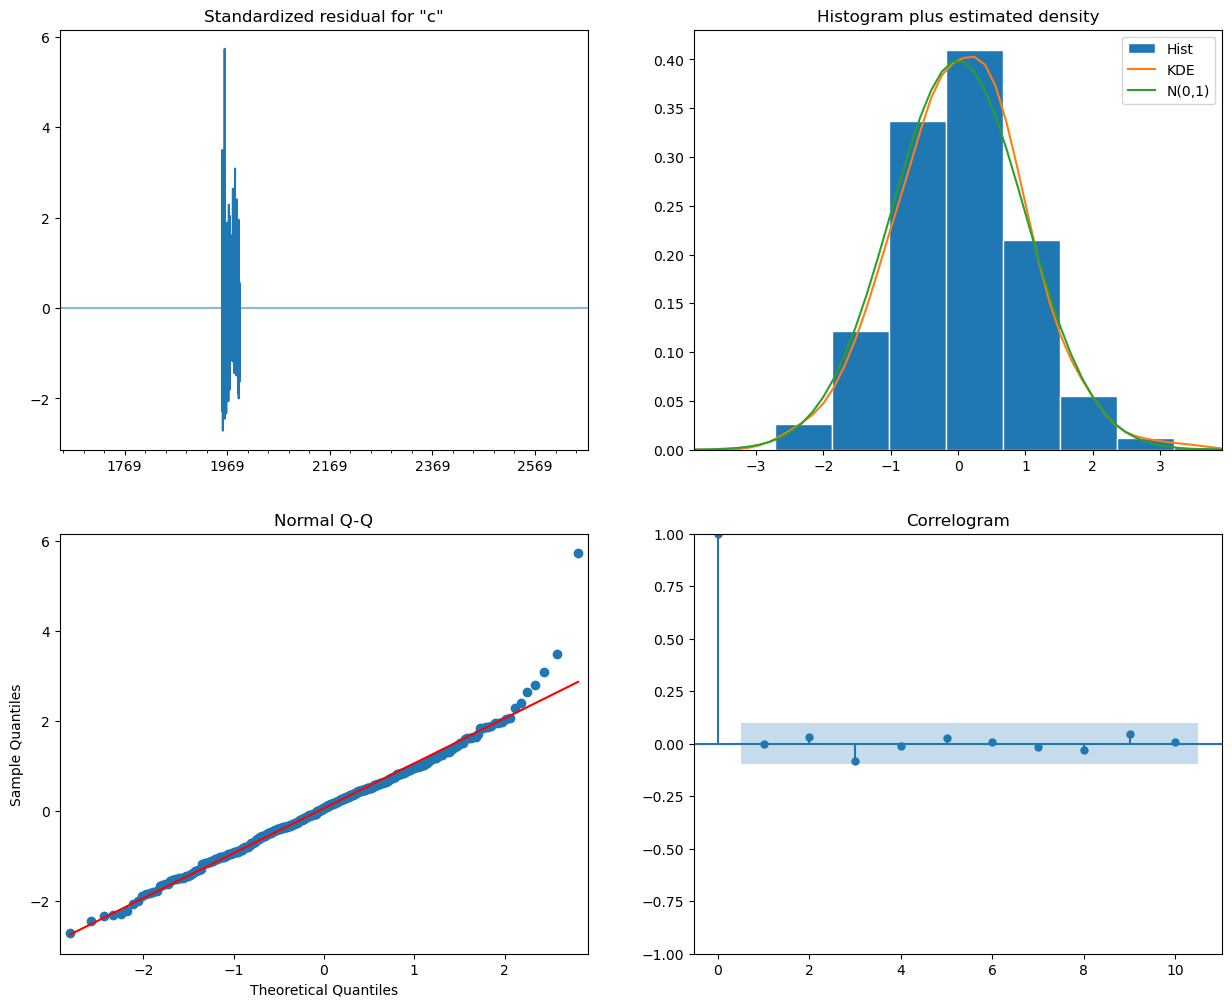

In [77]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

- In the top right plot, the red KDE line closely follows the N(0,1) line, indicating that the residuals exhibit a nearly normal distribution with a mean of 0 and a standard deviation of 1.

- The qq-plot on the bottom left aligns the ordered residuals with a linear trend, mirroring samples from a standard normal distribution N(0, 1). This reaffirms the normal distribution of the residuals.

- Moreover, the top left plot displaying residuals over time shows no apparent seasonality and resembles white noise. This pattern is consistent with the autocorrelation plot on the bottom right, where the residuals exhibit low correlation with past versions of themselves.

These findings suggest that the residuals of our model are These observations indicate that the residuals of our model are uncorrelated and provide a suitable fit for comprehending the time series data and making future forecasts.

In [78]:
# Forecast using the SARIMA model
forecast_steps = len(test_data)
sarima_forecast = sarima_model.forecast(steps=forecast_steps)

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

sarima_mae = mean_absolute_error(test_data, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))

# Print the MAE
print(f"Mean Absolute Error (MAE): {sarima_mae}")

# Print the RMSE
print(f"Root Mean Squared Error (RMSE): {sarima_rmse}")

Mean Absolute Error (MAE): 1.7011621838275945
Root Mean Squared Error (RMSE): 2.0216604226014177


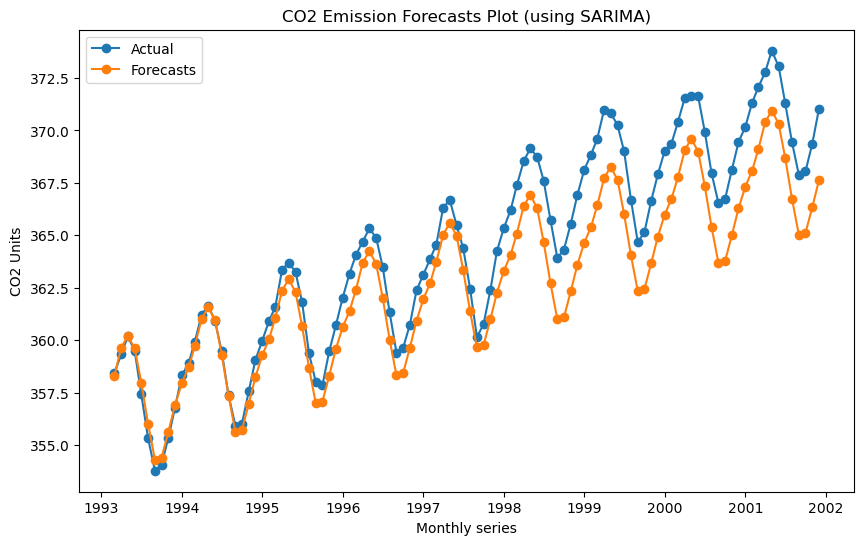

In [82]:
# Create a new figure
fig1, ax = plt.subplots(figsize=(10, 6))

# Plot Actual and Forecasted data
ax.plot(test_data.index, test_data, label='Actual', marker='o')
ax.plot(sarima_forecast.index, sarima_forecast, label='Forecasts', marker='o')

# Set the title and axis labels
ax.set_title("CO2 Emission Forecasts Plot (using SARIMA)")
ax.set_xlabel("Monthly series")
ax.set_ylabel("CO2 Units")

ax.legend()
plt.show()

### Exponential Smoothing Model

In [83]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [84]:
seasonal_periods = 12 #Monthly data
trend = 'add' #additive trend
seasonal = 'add'#additive seasonality

In [85]:
# Fit the additive exponential smoothing model to the training data
exp_model = ExponentialSmoothing(train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()

In [86]:
print(exp_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      co2   No. Observations:                  420
Model:             ExponentialSmoothing   SSE                             47.984
Optimized:                         True   AIC                           -879.139
Trend:                         Additive   BIC                           -814.495
Seasonal:                      Additive   AICC                          -877.433
Seasonal Periods:                    12   Date:                 Thu, 26 Oct 2023
Box-Cox:                          False   Time:                         19:00:00
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7455006                alpha                 True
smoothing_trend          

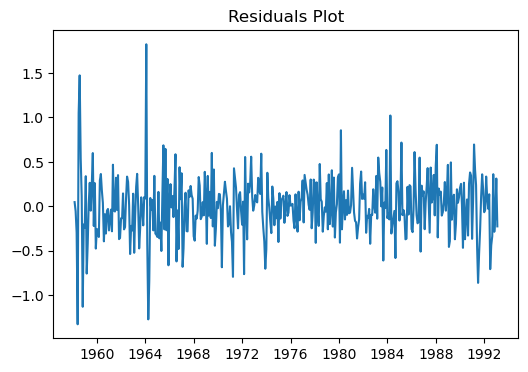

In [88]:
# Check residuals
residuals = exp_model.resid
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(residuals)
ax.set_title('Residuals Plot')
plt.show()

The residuals of the exponential smoothing model resemble white noise. Thus, the model is a good fit.

In [90]:
# Forecast using the SARIMA model
forecast_steps = len(test_data)
exp_forecast = exp_model.forecast(steps=forecast_steps)

In [91]:
exp_mae = mean_absolute_error(test_data, exp_forecast)
exp_rmse = np.sqrt(mean_squared_error(test_data, exp_forecast))

# Print the MAE
print(f"Mean Absolute Error (MAE): {exp_mae}")

# Print the RMSE
print(f"Root Mean Squared Error (RMSE): {exp_rmse}")

Mean Absolute Error (MAE): 2.4486447565917477
Root Mean Squared Error (RMSE): 2.8442687119026933


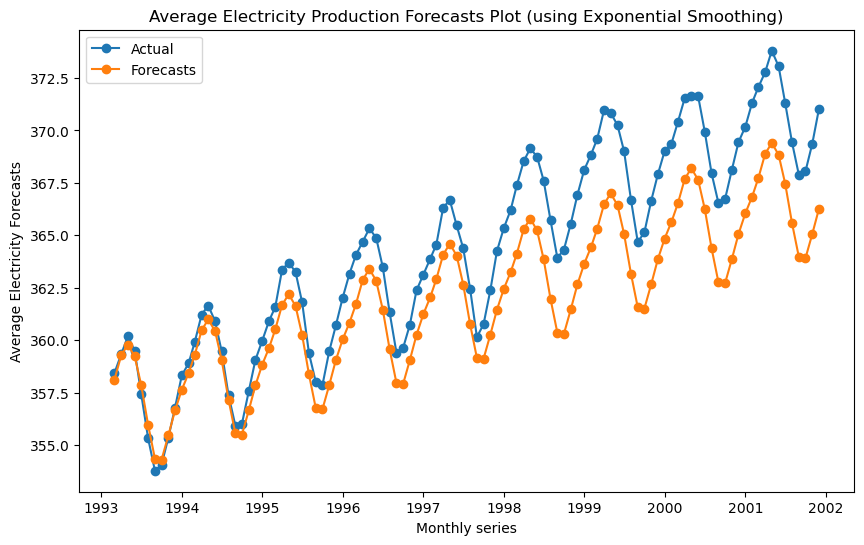

In [92]:
# Create a new figure
fig1, ax = plt.subplots(figsize=(10, 6))

# Plot Actual and Forecasted data
ax.plot(test_data.index, test_data, label='Actual', marker='o')
ax.plot(exp_forecast.index, exp_forecast, label='Forecasts', marker='o')

# Set the title and axis labels
ax.set_title("Average Electricity Production Forecasts Plot (using Exponential Smoothing)")
ax.set_xlabel("Monthly series")
ax.set_ylabel("Average Electricity Forecasts")

ax.legend()
plt.show()

### Model Comparison

In [93]:
# Data for model comparison
data = {
    'SARIMA': sarima_mae,
    'Exponential Smoothing': exp_mae
}

# Create a DataFrame
df = pd.DataFrame(data, index=["mae"])

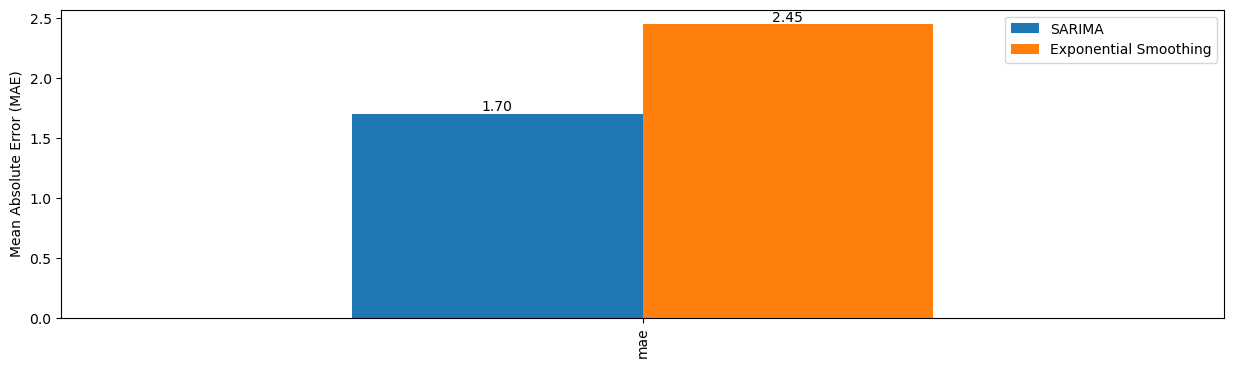

In [94]:
# Model comparison
fig, ax = plt.subplots(figsize=(15, 4))
ax = df.plot(kind="bar", ax=ax, legend=True)

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.ylabel("Mean Absolute Error (MAE)")

plt.show()

### BEST MODEL: SARIMA